# Taxi-v3

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt

imp.reload(logging)
logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

### Use Environment

In [2]:
env = gym.make('Taxi-v3')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

23:10:32 [INFO] env: <TaxiEnv<Taxi-v3>>
23:10:32 [INFO] action_space: Discrete(6)
23:10:32 [INFO] observation_space: Discrete(500)
23:10:32 [INFO] reward_range: (-inf, inf)
23:10:32 [INFO] metadata: {'render.modes': ['human', 'ansi']}
23:10:32 [INFO] _max_episode_steps: 200
23:10:32 [INFO] _elapsed_steps: None


In [3]:
state = env.reset()
taxirow, taxicol, passloc, destidx = env.unwrapped.decode(state)
logging.info('location of taxi = %s', (taxirow, taxicol))
logging.info('location of passager = %s', env.unwrapped.locs[passloc])
logging.info('location of destination = %s', env.unwrapped.locs[destidx])
env.render()

23:10:32 [INFO] location of taxi = (0, 1)
23:10:32 [INFO] location of passager = (0, 4)
23:10:32 [INFO] location of destination = (4, 0)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
env.step(0)

(126, -1, False, {'prob': 1.0})

In [5]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


### SARSA

In [6]:
class SARSAAgent:
    def __init__(self, env):
        self.gamma = 0.9
        self.learning_rate = 0.2
        self.epsilon = 0.01
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.uniform() < self.epsilon:
            action = np.random.randint(self.action_n)
        else:
            action = self.q[observation].argmax()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = \
                        self.trajectory[-8:]

        target = reward + self.gamma * \
                self.q[next_state, next_action] * (1. - done)
        td_error = target - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error


agent = SARSAAgent(env)

23:10:32 [INFO] ==== train ====
23:10:35 [INFO] ==== test ====
23:10:35 [INFO] average episode reward = 8.03 ± 2.50


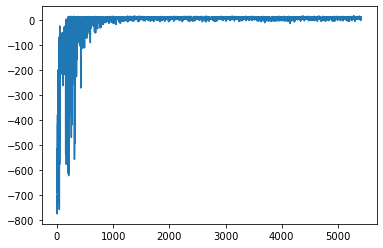

In [7]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-200:]) > 8:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

Show optimal action values

In [8]:
pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.487602,-3.095619,-3.095238,-3.851571,1.364833,-7.108184
2,-2.128847,1.632589,-2.144477,0.719892,7.568908,-2.268642
3,-3.597061,-3.596466,-2.821674,-2.618224,2.069454,-4.455161
4,-5.409483,-5.923042,-5.927367,-6.047687,-7.073330,-7.108867
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-3.102085,-2.970985,-2.883027,-3.022181,-3.600000,-3.636000
497,-1.681193,-0.878103,-1.704407,-1.658715,-3.600000,-3.636000
498,-3.119792,-3.005599,-3.150313,-3.150968,-5.014447,-3.636000


Show optimal policy

In [9]:
policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)] 
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,1.0,0.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
env.close()